In [1]:
import matplotlib as mpl
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as plt
from corner import corner

from gigalens.tf.inference import ModellingSequence
from gigalens.tf.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.tf.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.tf.profiles.light import sersic
from gigalens.tf.profiles.mass import epl, shear

sns.set_style("whitegrid")
tfd = tfp.distributions

In [2]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(tf.math.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(tf.math.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(tf.math.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(tf.math.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [65]:
prior.sample(2)

[[{'center_x': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.07527892, -0.02084341], dtype=float32)>,
   'center_y': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00265278, 0.03009612], dtype=float32)>,
   'e1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.03673645, -0.08951845], dtype=float32)>,
   'e2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.2574534 , -0.04322367], dtype=float32)>,
   'gamma': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.9471824, 2.0949032], dtype=float32)>,
   'theta_E': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.95435506, 1.1281447 ], dtype=float32)>},
  {'gamma1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.02756137, 0.01624046], dtype=float32)>,
   'gamma2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.02747097, 0.09051865], dtype=float32)>}],
 [{'Ie': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([583.03406, 392.96313], dtype=float32)>,
   'R_sersic': <tf.Tensor: shape=(2,), d

Load the data. The ground truth parameters are in `truth`. Various hyperparameters, including the noise scale and exposure time are fixed.

The PSF is generated from `TinyTim` for HST F140W band, and has been supersampled to the pixel scale of 0.065.

In [52]:
truth = [[
    {'theta_E': 1.1, 'gamma': 2.0, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
    {'gamma1': -0.01, 'gamma2': 0.03}
], [
    {'R_sersic': 0.8, 'n_sersic': 2.5, 'e1': 0.09534746574143645, 'e2': 0.14849487967198177, 'center_x': 0.1, 'center_y': 0.0, 'Ie': 499.3695906504067}
], [
    {'R_sersic': 0.25, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': 0.09566681002252231, 'center_y': -0.0639623054267272, 'Ie': 149.58828877085668}
]]

In [8]:
kernel = np.load('./assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load('./assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

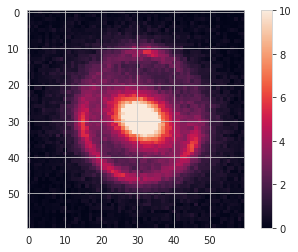

In [9]:
plt.imshow(observed_img, vmin=0, vmax=10)
plt.colorbar()

Sanity check: calculate residuals using ground truth.

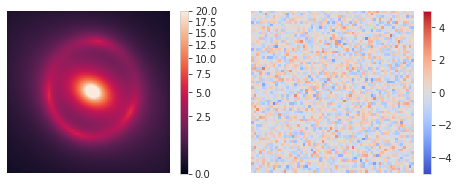

In [12]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.imshow(lens_sim.simulate(truth), norm=mpl.colors.PowerNorm(0.5, vmin=0, vmax=20),)
plt.colorbar()
plt.axis('off')
plt.subplot(122)
simulated = lens_sim.simulate(truth)
resid = simulated - observed_img
background_rms, exp_time = 0.2, 100
err_map = np.sqrt(background_rms**2 + simulated/exp_time)
plt.imshow(resid/err_map, cmap='coolwarm', interpolation='none', vmin=-5, vmax=5)
plt.axis('off')
plt.colorbar()

Begin fitting. We use `supersample=1` for this demonstration to speed things up, but setting `supersample=2` is recommended in practice. This will not significantly slow down the fitting.

In [13]:
fitter = ModellingSequence(phys_model, prob_model, sim_config)

In [15]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-2, 300, 1e-2/5)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
MAP = fitter.MAP(optimizer=optimizer, n_samples=500, num_steps=300, seed=0)

  0%|          | 0/300 [00:00<?, ?it/s]

In [25]:
lens_sim_500 = LensSimulator(phys_model, sim_config, bs=500)
lps = prob_model.log_prob(lens_sim_500, MAP)[0]
best = MAP[tf.argmax(lps).numpy()]

In [30]:
schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.0, 500, 4e-3, 2)
optimizer = tf.keras.optimizers.Adam(schedule_fn)
q_z, losses = fitter.SVI(optimizer=optimizer, start=best, n_vi=500, num_steps=1000)

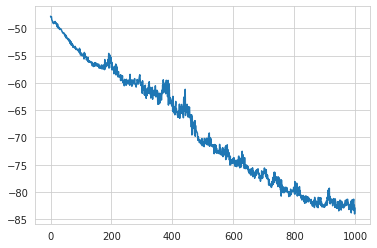

In [31]:
plt.plot(losses)

In [32]:
samples, sample_stats = fitter.HMC(q_z, n_hmc=50, init_eps=0.3, init_l=3, max_leapfrog_steps=300,
                                   num_burnin_steps=250, num_results=750)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


  0%|          | 0/999 [00:00<?, ?it/s]

In [38]:
Rhat = tfp.mcmc.potential_scale_reduction(samples).numpy()
ESS = tfp.mcmc.effective_sample_size(samples, cross_chain_dims=1).numpy()
print(Rhat, ESS)

[1.0005556 1.0006979 1.0031219 1.002358  1.004739  1.0007187 1.0030862
 1.0027432 1.0002941 1.0004379 1.0003054 1.0005633 1.0000432 0.999814
 1.000201  1.0014998 1.0015363 1.0002365 1.0044318 1.0005832 1.000417
 1.001184 ] [30107.53  28963.291 19207.55  20127.861 11264.19  20513.621 12481.879
 14719.481 28876.713 28825.37  27733.463 26871.676 29399.668 28891.37
 28779.734 21598.947 19498.256 30540.23  12070.103 25949.781 26441.248
 22076.94 ]


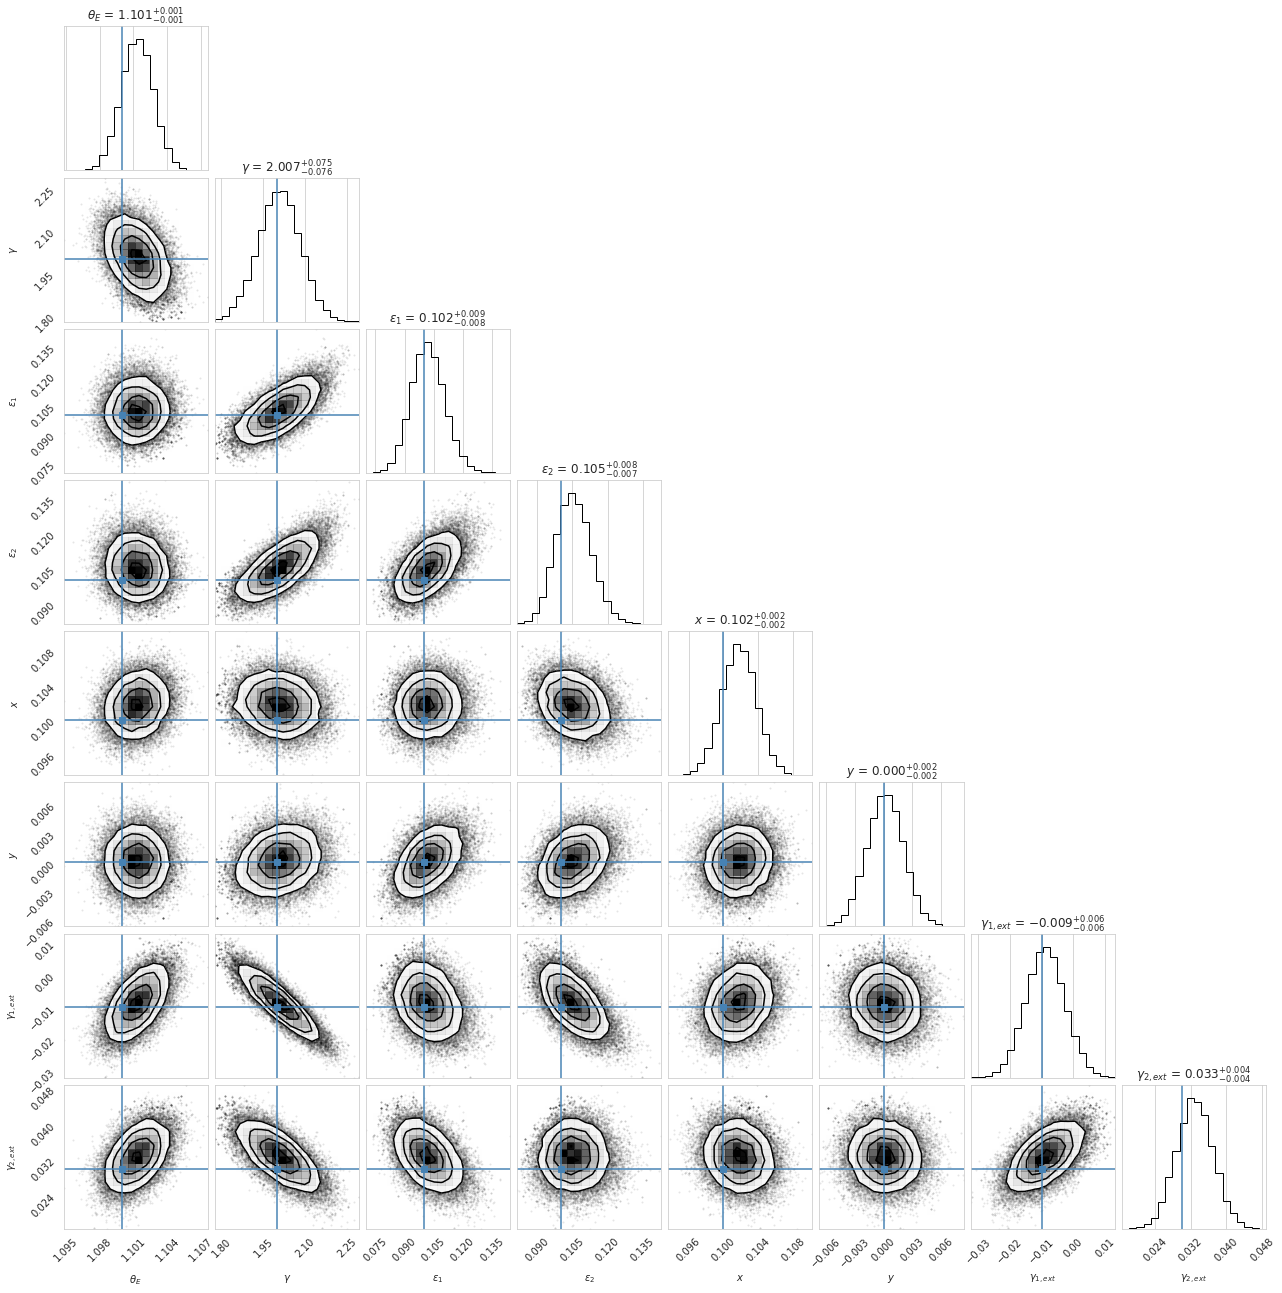

In [63]:
get_samples = lambda x: tf.convert_to_tensor([
    x[0][0]['theta_E'],
    x[0][0]['gamma'],
    x[0][0]['e1'],
    x[0][0]['e2'],
    x[0][0]['center_x'],
    x[0][0]['center_y'],
    x[0][1]['gamma1'],
    x[0][1]['gamma2'],
])
physical_samples = get_samples(prob_model.bij.forward(samples)).numpy()
markers = get_samples(truth)
corner(physical_samples.reshape((8,-1)).T, truths=markers, 
       show_titles=True, title_fmt='.3f',
       labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);